In [20]:
%reload_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')

import numpy as np
from ddpg_agent.contrib.physics_sim import PhysicsSim

class Task():
    """Task (environment) that defines the goal and provides feedback to the agent."""
    def __init__(self, init_pose=None, init_velocities=None, 
        init_angle_velocities=None, runtime=10., target_pos=None, target_steps_within_goal=3):
        """Initialize a Task object.
        Params
        ======
            init_pose: initial position of the quadcopter in (x,y,z) dimensions and the Euler angles
            init_velocities: initial velocity of the quadcopter in (x,y,z) dimensions
            init_angle_velocities: initial radians/second for each of the three Euler angles
            runtime: time limit for each episode
            target_pos: target/goal (x,y,z) position for the agent
        """
        # Simulation
        self.sim = PhysicsSim(init_pose, init_velocities, init_angle_velocities, runtime) 
        # TODO: Make action_repeat align with agent.action_repeat
        self.action_repeat = 3

        self.state_size = self.action_repeat * 6
        self.observation_space = Space( list(self.sim.lower_bounds) + [ 0 ]*3, 
                                       list(self.sim.upper_bounds) + [ 1 ]*3 )
        self.state_size = 6
        self.action_space = Space([0,0,0,0], [900,900,900,900])
        self.action_size = 4

        # Goal
        self.target_pos = target_pos if target_pos is not None else np.array([0., 0., 10.])
        self.steps_within_goal = 0
        self.target_steps_within_goal = target_steps_within_goal
        
    def reached_goal(self, horiz_dist_thresh=2, vert_dist_thresh=1):
        horiz_distance_from_goal = np.sqrt((self.sim.pose[0]-self.target_pos[0])**2
                                           +(self.sim.pose[1]-self.target_pos[1])**2)
        vert_distance_from_goal = np.abs(self.sim.pose[2]-self.target_pos[2])
        return horiz_distance_from_goal < horiz_dist_thresh and \
                vert_distance_from_goal <= vert_dist_thresh

    def get_reward(self):
        """Uses current pose of sim to return reward."""
        #reward = 1.-.3*(abs(self.sim.pose[:3] - self.target_pos)).sum()
        reward = 0
        # Reward for staying at target altitude
#         reward = (self.target_pos[2] - np.abs(self.sim.pose[2] - self.target_pos[2]))/self.target_pos[2]
        #Intermediate reward for flying at altitude
        if np.abs(self.sim.pose[2] - self.target_pos[2]) < 1:
            reward += 1
        # Punishment for crashing (altitude < 1 m)
#         if self.sim.pose[2]<=0: reward -= 100
#         if self.sim.pose[2]<2: reward -= 1
        # Reward for being within goal radius
#         horiz_distance_from_goal = np.sqrt((self.sim.pose[0]-self.target_pos[0])**2
#                                            +(self.sim.pose[1]-self.target_pos[1])**2)
        # Reward i for going up
        if self.sim.v[2]>0:
            reward += 1
        if self.reached_goal(): 
            self.steps_within_goal += 1
            reward += 100
            if self.steps_within_goal / self.action_repeat >= self.target_steps_within_goal: 
                reward += 1000
        else:
            self.steps_within_goal = 0
        return reward

    def step(self, rotor_speeds):
        """Uses action to obtain next state, reward, done."""
        reward = 0
        pose_all = []
        for _ in range(self.action_repeat):
            done = self.sim.next_timestep(rotor_speeds) # update the sim pose and velocities
            reward += self.get_reward() 
            pose_all.append(self.sim.pose)
        next_state = np.concatenate(pose_all)
#             import pdb; pdb.set_trace()
        # end episode if at goal state
        if self.steps_within_goal / self.action_repeat >= self.target_steps_within_goal: 
            done = True
        return next_state, reward, done, None

    def reset(self):
        """Reset the sim to start a new episode."""
        self.sim.reset()
        state = np.concatenate([self.sim.pose] * self.action_repeat) 
#         state = self.sim.pose
        self.steps_within_goal = 0
        return state

class Space():
    def __init__(self, low, high):
        low = np.array(low)
        high = np.array(high)
        assert low.shape == high.shape,\
            "Expected bounds to be of same shape."
        self.low = low
        self.high = high
        self.shape = low.shape

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import normalize
%matplotlib inline

def plot_episode(episode):
    # goal_position = agent.env.target_pos
    fig = plt.figure(figsize=(13,7))
    fig.suptitle("Episode %i, score: %.3f, epsilon: %.3f"%(episode.episode_idx, episode.score, episode.epsilon))

    main_cols = gridspec.GridSpec(1, 2, figure=fig)
    right_col_grid = main_cols[1].subgridspec(2,2,wspace=.2,hspace=.3)

    reward_cmap=mpl.cm.ScalarMappable(cmap=mpl.cm.get_cmap('RdYlGn'))
    reward_cmap.set_array([])
    reward_cmap.set_clim(min(episode.rewards),max(episode.rewards))
    
    pos_ax = fig.add_subplot(main_cols[0], projection='3d', title="Flight Path")
    pos_scatter = pos_ax.scatter([s[0] for s in episode.states], [s[1] for s in episode.states], 
                                 [s[2] for s in episode.states], c=[reward_cmap.to_rgba(r) for r in episode.rewards] )

    fig.colorbar(reward_cmap, ax=pos_ax, shrink=.5, pad=.02, label="reward", orientation='horizontal')

    alt_ax = fig.add_subplot(right_col_grid[0,0], title="Altitude", xlabel='step')
    alt_ax.plot([s[2] for s in episode.states], color='magenta')


    actions_grid = right_col_grid[0,1].subgridspec(4,1)
    def plot_action(i):
#         a_colors=['darkorange','darkgoldenrod','peru','lightsalmon']
        ax = fig.add_subplot(actions_grid[i], ylim=(-100,1000), xlabel='step', yticks=[0,400,800])
#         if i==0: ax.set_title('Actions')
        ax.plot([a[i] for a in episode.raw_actions], color='gray', label='raw action')
        ax.plot([a[i] for a in episode.actions], label='action + noise', color='darkorange')#a_colors[i])
        if i==0: ax.legend(loc='lower center', bbox_to_anchor=(.5,.9))
    for i in range(4): plot_action(i)
    
    def plot_state(ax,i):
        s_colors=['slateblue','royalblue','magenta','steelblue','skyblue','deepskyblue']
        s_labels=['x pos','y pos','altitude','roll', 'pitch', 'yaw']
        state=np.array([s[i] for s in episode.states])
        ax.plot(normalize(state.reshape(-1,1),axis=0), color=s_colors[i], label=s_labels[i])

    rot_ax = fig.add_subplot(right_col_grid[1,1], title="Rotation", xlabel='step')
    for i in range(3,6): plot_state(rot_ax,i)
    rot_ax.legend(loc='upper right')

    horiz_pos_ax = fig.add_subplot(right_col_grid[1,0], title="Horizontal Position")
    horiz_pos_ax.scatter([s[0] for s in episode.states], [s[1] for s in episode.states], 
                         c=[reward_cmap.to_rgba(r) for r in episode.rewards])
        
    fig.show()
# for ep in agent.history.training_episodes[:6]:
#     plot_episode(ep)
# plot_episode(agent.history.test_episodes[71])
# plot_episode(agent.history.training_episodes[80])

In [40]:
# import csv
from ddpg_agent.agent import DDPG, Q_a_frames_spec

runtime = 10.                                     # time limit of the episode
init_pose = np.array([0., 0., 8.5, 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup

task = Task(init_pose, init_velocities, init_angle_velocities, runtime)

q_a_frames_spec = Q_a_frames_spec(task, nx=16, ny=16, na=11, x_dim=4, y_dim=2, a_dim=0)

agent = DDPG(task, ou_mu=0, ou_theta=.1, ou_sigma=300, 
             discount_factor=.999, replay_buffer_size=100000, replay_batch_size=1024,
             tau_actor=.1, tau_critic=.3, 
             relu_alpha_actor=.01, relu_alpha_critic=.01,
             lr_actor=.0001, lr_critic=.001, activation_fn_actor='tanh',
             l2_reg_actor=.01, l2_reg_critic=.01, 
             bn_momentum_actor=0, bn_momentum_critic=.7, 
             q_a_frames_spec=q_a_frames_spec,
            )
# agent.print_summary()

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
# [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)

First let's try 100 training episodes with eps fixed at 1

In [41]:
agent.train_n_episodes(100, eps=2, eps_decay=0, action_repeat=1, run_tests=True, gen_q_a_frames_every_n_steps=0 )

Episode 1 - epsilon: 2.00, memory size: 22, num steps: 22, training score: 2.00, test score: 26.00
Episode 2 - epsilon: 2.00, memory size: 51, num steps: 29, training score: 9.00, test score: 26.00
Episode 3 - epsilon: 2.00, memory size: 71, num steps: 20, training score: 1.00, test score: 26.00
Episode 4 - epsilon: 2.00, memory size: 97, num steps: 26, training score: 5.00, test score: 26.00
Episode 5 - epsilon: 2.00, memory size: 121, num steps: 24, training score: 1.00, test score: 26.00
Episode 6 - epsilon: 2.00, memory size: 145, num steps: 24, training score: 2.00, test score: 26.00
Episode 7 - epsilon: 2.00, memory size: 171, num steps: 26, training score: 8.00, test score: 26.00
Episode 8 - epsilon: 2.00, memory size: 192, num steps: 21, training score: 1.00, test score: 26.00
Episode 9 - epsilon: 2.00, memory size: 216, num steps: 24, training score: 0.00, test score: 26.00
Episode 10 - epsilon: 2.00, memory size: 242, num steps: 26, training score: 0.00, test score: 26.00
Epi

Episode 82 - epsilon: 2.00, memory size: 1905, num steps: 22, training score: 1.00, test score: 4135.00
Episode 83 - epsilon: 2.00, memory size: 1928, num steps: 23, training score: 1.00, test score: 4135.00
Episode 84 - epsilon: 2.00, memory size: 1953, num steps: 25, training score: 9.00, test score: 4135.00
Episode 85 - epsilon: 2.00, memory size: 1976, num steps: 23, training score: 1.00, test score: 4135.00
Episode 86 - epsilon: 2.00, memory size: 1999, num steps: 23, training score: 3.00, test score: 4135.00
Episode 87 - epsilon: 2.00, memory size: 2022, num steps: 23, training score: 0.00, test score: 4135.00
Episode 88 - epsilon: 2.00, memory size: 2043, num steps: 21, training score: 2.00, test score: 4135.00
Episode 89 - epsilon: 2.00, memory size: 2071, num steps: 28, training score: 16.00, test score: 4135.00
Episode 90 - epsilon: 2.00, memory size: 2095, num steps: 24, training score: 3.00, test score: 4135.00
Episode 91 - epsilon: 2.00, memory size: 2117, num steps: 22, t

In [44]:
agent.train_n_episodes(100, eps=1.5, eps_decay=0, action_repeat=1, run_tests=True, gen_q_a_frames_every_n_steps=0 )

Episode 101 - epsilon: 1.50, memory size: 2352, num steps: 22, training score: 8.00, test score: 4135.00
Episode 102 - epsilon: 1.50, memory size: 2378, num steps: 26, training score: 7.00, test score: 4135.00
Episode 103 - epsilon: 1.50, memory size: 2400, num steps: 22, training score: 2.00, test score: 4135.00
Episode 104 - epsilon: 1.50, memory size: 2426, num steps: 26, training score: 1.00, test score: 4135.00
Episode 105 - epsilon: 1.50, memory size: 2450, num steps: 24, training score: 7.00, test score: 4135.00
Episode 106 - epsilon: 1.50, memory size: 2470, num steps: 20, training score: 1.00, test score: 4135.00
Episode 107 - epsilon: 1.50, memory size: 2495, num steps: 25, training score: 4.00, test score: 4135.00
Episode 108 - epsilon: 1.50, memory size: 2517, num steps: 22, training score: 4.00, test score: 4135.00
Episode 109 - epsilon: 1.50, memory size: 2539, num steps: 22, training score: 5.00, test score: 4135.00
Episode 110 - epsilon: 1.50, memory size: 2567, num ste

Episode 179 - epsilon: 1.50, memory size: 4138, num steps: 36, training score: 13.00, test score: 4135.00
Episode 180 - epsilon: 1.50, memory size: 4162, num steps: 24, training score: 0.00, test score: 4135.00
Episode 181 - epsilon: 1.50, memory size: 4179, num steps: 17, training score: 1.00, test score: 4135.00
Episode 182 - epsilon: 1.50, memory size: 4200, num steps: 21, training score: 0.00, test score: 4135.00
Episode 183 - epsilon: 1.50, memory size: 4208, num steps: 8, training score: 4135.00, test score: 4135.00
Episode 184 - epsilon: 1.50, memory size: 4231, num steps: 23, training score: 1.00, test score: 4135.00
Episode 185 - epsilon: 1.50, memory size: 4262, num steps: 31, training score: 13.00, test score: 4135.00
Episode 186 - epsilon: 1.50, memory size: 4285, num steps: 23, training score: 0.00, test score: 4135.00
Episode 187 - epsilon: 1.50, memory size: 4307, num steps: 22, training score: 0.00, test score: 4135.00
Episode 188 - epsilon: 1.50, memory size: 4338, num

In [45]:
agent.train_n_episodes(100, eps=.5, eps_decay=0, action_repeat=1, run_tests=True, gen_q_a_frames_every_n_steps=0 )

Episode 201 - epsilon: 0.50, memory size: 4630, num steps: 25, training score: 3.00, test score: 4135.00
Episode 202 - epsilon: 0.50, memory size: 4657, num steps: 27, training score: 5.00, test score: 4135.00
Episode 203 - epsilon: 0.50, memory size: 4665, num steps: 8, training score: 3033.00, test score: 4135.00
Episode 204 - epsilon: 0.50, memory size: 4688, num steps: 23, training score: 7.00, test score: 4135.00
Episode 205 - epsilon: 0.50, memory size: 4711, num steps: 23, training score: 4.00, test score: 4135.00
Episode 206 - epsilon: 0.50, memory size: 4759, num steps: 48, training score: 608.00, test score: 4135.00
Episode 207 - epsilon: 0.50, memory size: 4782, num steps: 23, training score: 3.00, test score: 4135.00
Episode 208 - epsilon: 0.50, memory size: 4802, num steps: 20, training score: 16.00, test score: 4135.00
Episode 209 - epsilon: 0.50, memory size: 4828, num steps: 26, training score: 2.00, test score: 4135.00
Episode 210 - epsilon: 0.50, memory size: 4836, nu

Episode 280 - epsilon: 0.50, memory size: 6408, num steps: 16, training score: 4.00, test score: 3028.00
Episode 281 - epsilon: 0.50, memory size: 6428, num steps: 20, training score: 3.00, test score: 3028.00
Episode 282 - epsilon: 0.50, memory size: 6454, num steps: 26, training score: 12.00, test score: 3028.00
Episode 283 - epsilon: 0.50, memory size: 6461, num steps: 7, training score: 4132.00, test score: 3028.00
Episode 284 - epsilon: 0.50, memory size: 6479, num steps: 18, training score: 3.00, test score: 3028.00
Episode 285 - epsilon: 0.50, memory size: 6485, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 286 - epsilon: 0.50, memory size: 6491, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 287 - epsilon: 0.50, memory size: 6518, num steps: 27, training score: 16.00, test score: 3028.00
Episode 288 - epsilon: 0.50, memory size: 6543, num steps: 25, training score: 3.00, test score: 3028.00
Episode 289 - epsilon: 0.50, memory size: 6567,

In [47]:
agent.train_n_episodes(100, eps=.2, eps_decay=0, action_repeat=1, run_tests=True, gen_q_a_frames_every_n_steps=0 )

Episode 301 - epsilon: 0.20, memory size: 6811, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 302 - epsilon: 0.20, memory size: 6817, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 303 - epsilon: 0.20, memory size: 6823, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 304 - epsilon: 0.20, memory size: 6829, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 305 - epsilon: 0.20, memory size: 6846, num steps: 17, training score: 721.00, test score: 3028.00
Episode 306 - epsilon: 0.20, memory size: 6852, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 307 - epsilon: 0.20, memory size: 6858, num steps: 6, training score: 1927.00, test score: 3028.00
Episode 308 - epsilon: 0.20, memory size: 6873, num steps: 15, training score: 9.00, test score: 3028.00
Episode 309 - epsilon: 0.20, memory size: 6892, num steps: 19, training score: 213.00, test score: 3028.00
Episode 310 - epsilon: 0.20, memory siz

Episode 378 - epsilon: 0.20, memory size: 7736, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 379 - epsilon: 0.20, memory size: 7742, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 380 - epsilon: 0.20, memory size: 7748, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 381 - epsilon: 0.20, memory size: 7754, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 382 - epsilon: 0.20, memory size: 7760, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 383 - epsilon: 0.20, memory size: 7766, num steps: 6, training score: 1927.00, test score: 3028.00
Episode 384 - epsilon: 0.20, memory size: 7805, num steps: 39, training score: 1928.00, test score: 3028.00
Episode 385 - epsilon: 0.20, memory size: 7811, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 386 - epsilon: 0.20, memory size: 7817, num steps: 6, training score: 3028.00, test score: 3028.00
Episode 387 - epsilon: 0.20, memory 

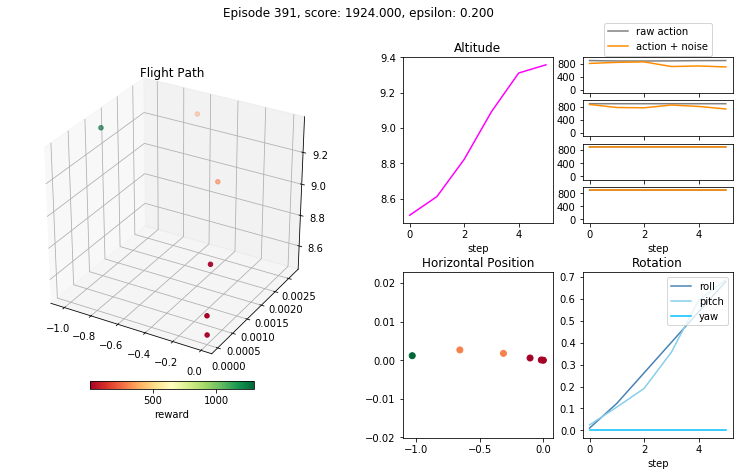

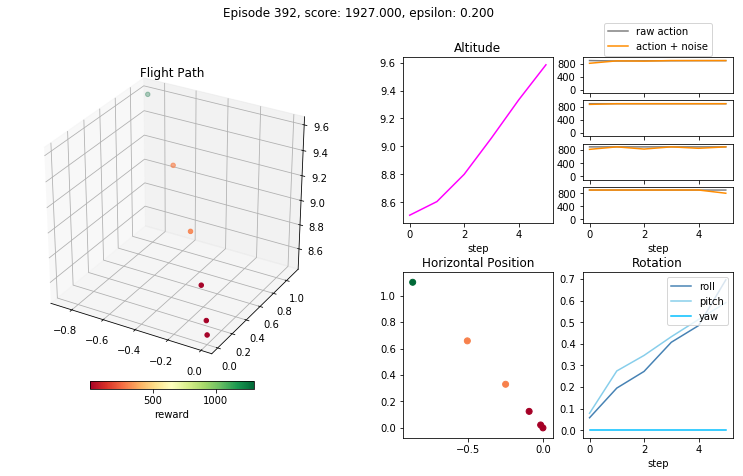

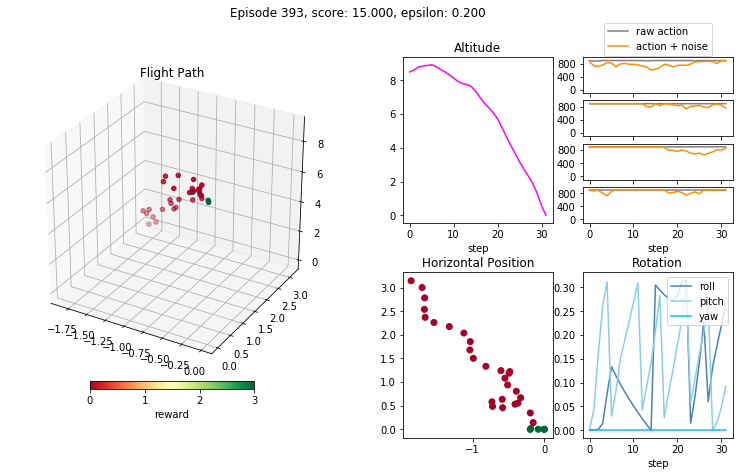

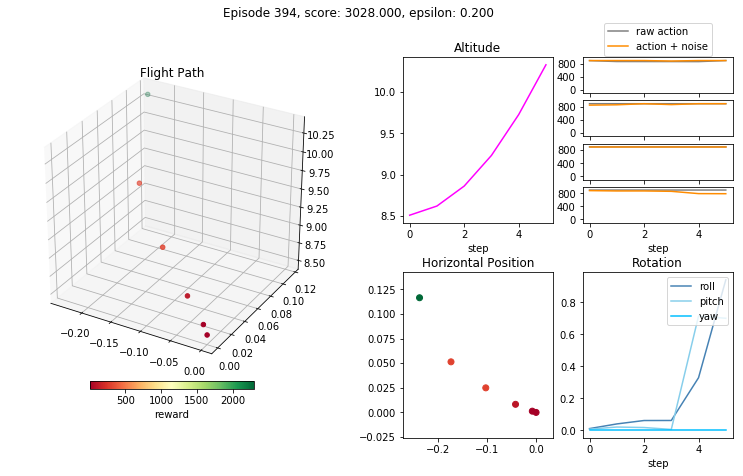

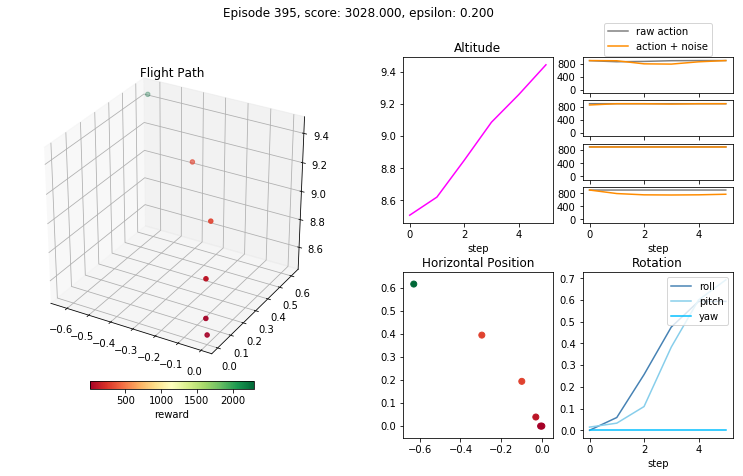

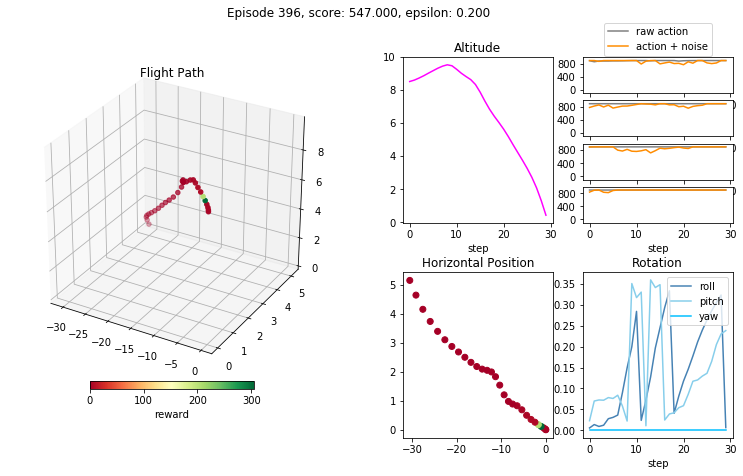

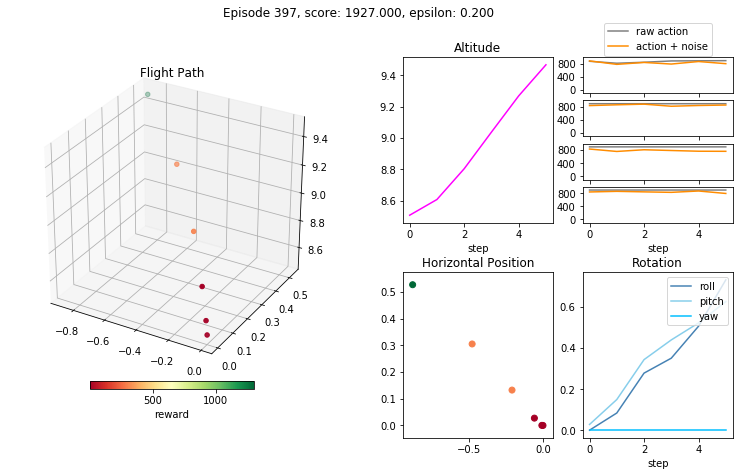

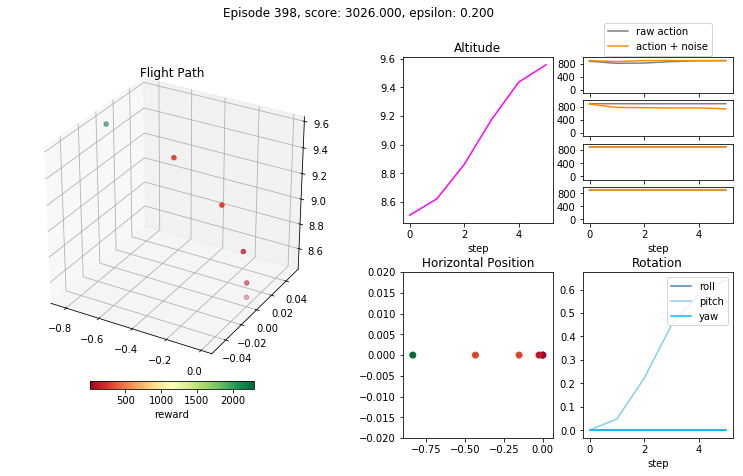

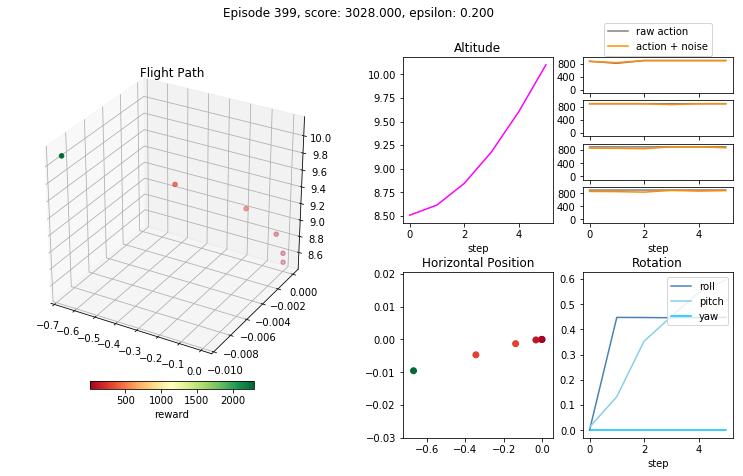

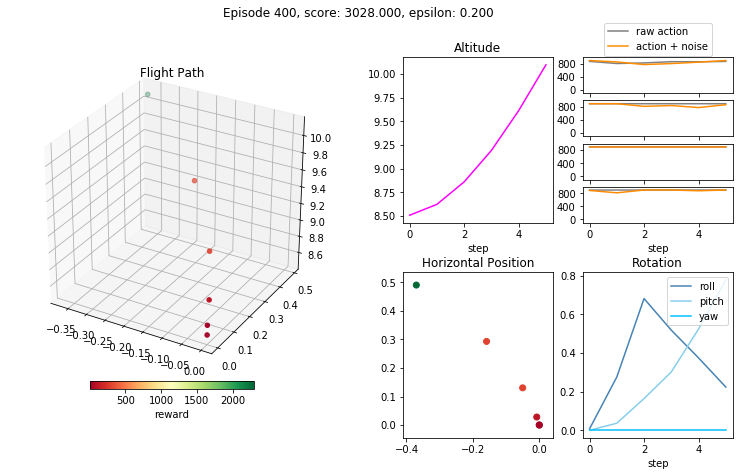

In [49]:
for ep in agent.history.training_episodes[-10:]:
    plot_episode(ep)

In [ ]:
plot_episode(agent.history.training_episodes[-1])